In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/8q/kf4dndkj2zz0h4h9x0xscv0w0000gn/T/ipykernel_64685/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


For this project I used the **London Underground Data**.

### Data Preprocessing

In [2]:
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import geopy.distance
import heapq




In [3]:
df_con = pd.read_csv("connections.csv")
df_line = pd.read_csv("lines.csv")
df_sta = pd.read_csv("stations.csv")

In [4]:
df_con

,Unnamed: 0,station1,station2,line,time,distance(miles)
0,0,11,163,1,1.0,0.257855
1,1,11,212,1,2.0,0.454449
2,2,49,87,1,1.0,0.111148
3,3,49,197,1,2.0,0.426744
4,4,82,163,1,2.0,0.273407
...,...,...,...,...,...,...
428,428,326,327,14,NaN,6.740020
429,429,327,328,14,NaN,4.810656
430,430,319,330,14,NaN,2.606461
431,431,330,331,14,NaN,NaN


In [5]:
df_con.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       433 non-null    int64  
 1   station1         433 non-null    int64  
 2   station2         433 non-null    int64  
 3   line             433 non-null    int64  
 4   time             406 non-null    float64
 5   distance(miles)  429 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 20.4 KB


In [6]:
df_line

,line,name,colour
0,1,Bakerloo Line,AE6017
1,2,Central Line,F15B2E
2,3,Circle Line,FFE02B
3,4,District Line,00A166
4,5,East London Line,FBAE34
5,6,Hammersmith & City Line,F491A8
6,7,Jubilee Line,949699
7,8,Metropolitan Line,91005A
8,9,Northern Line,000000
9,10,Piccadilly Line,094FA3


In [7]:
df_sta

,Unnamed: 0,latitude,longitude,name,zone,total_lines,rail
0,1,51.502800,-0.280100,Acton Town,3.0,2.0,0.0
1,2,51.514300,-0.075500,Aldgate,1.0,2.0,0.0
2,3,51.515400,-0.072600,Aldgate East,1.0,2.0,0.0
3,4,51.510700,-0.013000,All Saints,2.0,1.0,0.0
4,5,51.540700,-0.299700,Alperton,4.0,1.0,0.0
...,...,...,...,...,...,...,...
327,329,51.503095,-0.420452,Hayes & Harlington,5,NaN,NaN
328,330,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN
329,331,NaN,NaN,Heathrow Terminals 4,NaN,NaN,NaN
330,332,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN


In [8]:
df_sta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   332 non-null    int64  
 1   latitude     328 non-null    float64
 2   longitude    328 non-null    float64
 3   name         332 non-null    object 
 4   zone         328 non-null    object 
 5   total_lines  302 non-null    float64
 6   rail         302 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 18.3+ KB


In [9]:
df_sta = df_sta.rename(columns={'Unnamed: 0': 'station'})
df_sta

,station,latitude,longitude,name,zone,total_lines,rail
0,1,51.502800,-0.280100,Acton Town,3.0,2.0,0.0
1,2,51.514300,-0.075500,Aldgate,1.0,2.0,0.0
2,3,51.515400,-0.072600,Aldgate East,1.0,2.0,0.0
3,4,51.510700,-0.013000,All Saints,2.0,1.0,0.0
4,5,51.540700,-0.299700,Alperton,4.0,1.0,0.0
...,...,...,...,...,...,...,...
327,329,51.503095,-0.420452,Hayes & Harlington,5,NaN,NaN
328,330,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN
329,331,NaN,NaN,Heathrow Terminals 4,NaN,NaN,NaN
330,332,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN


In [10]:
# merge to get latitiude and longitude information of station 1 and station 2 into one table
df_merged = df_con.merge(df_sta[['station', 'latitude', 'longitude']],\
                         left_on='station1', right_on='station',\
                         how='left').rename(columns={'latitude': 'latitude1', 'longitude': 'longitude1'}).drop(columns=['station'])

df_merged = df_merged.merge(df_sta[['station', 'latitude', 'longitude']],\
                         left_on='station2', right_on='station',\
                         how='left').rename(columns={'latitude': 'latitude2', 'longitude': 'longitude2'}).drop(columns=['station'])

df_merged = df_merged.drop(columns=['Unnamed: 0'])
df_merged

,station1,station2,line,time,distance(miles),latitude1,longitude1,latitude2,longitude2
0,11,163,1,1.0,0.257855,51.522600,-0.157100,51.522500,-0.163100
1,11,212,1,2.0,0.454449,51.522600,-0.157100,51.523400,-0.146600
2,49,87,1,1.0,0.111148,51.508000,-0.124700,51.507400,-0.122300
3,49,197,1,2.0,0.426744,51.508000,-0.124700,51.509800,-0.134200
4,82,163,1,2.0,0.273407,51.519900,-0.167900,51.522500,-0.163100
...,...,...,...,...,...,...,...,...,...
428,326,327,14,NaN,6.740020,51.518538,-0.722533,51.475462,-0.863242
429,327,328,14,NaN,4.810656,51.475462,-0.863242,51.458688,-0.971795
430,319,330,14,NaN,2.606461,51.503095,-0.420452,51.471318,-0.453178
431,330,331,14,NaN,NaN,51.471318,-0.453178,NaN,NaN


In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   station1         433 non-null    int64  
 1   station2         433 non-null    int64  
 2   line             433 non-null    int64  
 3   time             406 non-null    float64
 4   distance(miles)  429 non-null    float64
 5   latitude1        432 non-null    float64
 6   longitude1       432 non-null    float64
 7   latitude2        430 non-null    float64
 8   longitude2       430 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 30.6 KB


In [12]:
# only drop null value for the columns we used
df_merged.dropna(subset=['station1', 'station2', 'distance(miles)', 'latitude1', 'longitude1', 'latitude2', 'longitude2'], inplace=True)
# df_merged.dropna(inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 0 to 430
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   station1         429 non-null    int64  
 1   station2         429 non-null    int64  
 2   line             429 non-null    int64  
 3   time             406 non-null    float64
 4   distance(miles)  429 non-null    float64
 5   latitude1        429 non-null    float64
 6   longitude1       429 non-null    float64
 7   latitude2        429 non-null    float64
 8   longitude2       429 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 33.5 KB


### 1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

In [13]:
# use latitude and longitude to calculate the straight-line distance
def calculate_distance(row):
    coords_1 = (row["latitude1"], row["longitude1"])
    coords_2 = (row["latitude2"], row["longitude2"])
    return geopy.distance.geodesic(coords_1, coords_2).miles # shortest distance between two points in miles

df_merged["straight_distance(miles)"] = df_merged.apply(calculate_distance, axis=1) # apply the function to each row of the table
df_merged

,station1,station2,line,time,distance(miles),latitude1,longitude1,latitude2,longitude2,straight_distance(miles)
0,11,163,1,1.0,0.257855,51.522600,-0.157100,51.522500,-0.163100,0.258855
1,11,212,1,2.0,0.454449,51.522600,-0.157100,51.523400,-0.146600,0.456194
2,49,87,1,1.0,0.111148,51.508000,-0.124700,51.507400,-0.122300,0.111538
3,49,197,1,2.0,0.426744,51.508000,-0.124700,51.509800,-0.134200,0.428305
4,82,163,1,2.0,0.273407,51.519900,-0.167900,51.522500,-0.163100,0.274160
...,...,...,...,...,...,...,...,...,...,...
426,324,325,14,NaN,1.514774,51.523393,-0.646248,51.523419,-0.681509,1.520650
427,325,326,14,NaN,1.794392,51.523419,-0.681509,51.518538,-0.722533,1.801187
428,326,327,14,NaN,6.740020,51.518538,-0.722533,51.475462,-0.863242,6.762726
429,327,328,14,NaN,4.810656,51.475462,-0.863242,51.458688,-0.971795,4.828572


In [14]:
# get the graph using stations as nodes
graph = defaultdict(dict) # use defaultdict of dict, dont't need to initialize the key, value is empty dict as default

for s1, s2, d, d_stra in zip(df_merged['station1'], df_merged['station2'], df_merged['distance(miles)'], df_merged['straight_distance(miles)']):
    graph[s1][s2] = (d, d_stra)
    graph[s2][s1] = (d, d_stra)  # ensure undirected graph

graph

defaultdict(dict,
            {11: {163: (0.2578548159421427, 0.258854570814782),
              212: (0.4544490120424679, 0.4561943476084075),
              83: (0.5765059236633674, 0.5786280480800992),
              104: (0.5730900349617465, 0.575281860794851),
              28: (0.6676990103255461, 0.6689729778591339),
              249: (1.1067751955680578, 1.1094227070686071),
              94: (1.969207767506565, 1.9730239049652618)},
             163: {11: (0.2578548159421427, 0.258854570814782),
              82: (0.2734073924417827, 0.2741602194020883)},
             212: {11: (0.4544490120424679, 0.4561943476084075),
              192: (0.6199900588250575, 0.6209775644956569)},
             49: {87: (0.1111475173304513, 0.1115382526595991),
              197: (0.4267443156546505, 0.4283048530047108),
              151: (0.2706703684070302, 0.2712189526651564)},
             87: {49: (0.1111475173304513, 0.1115382526595991),
              279: (0.4324876298931259, 0.43374906805

In [15]:
def mst_cost(G, distance_type, start_index): #iteratively selects the shortest edge while maintaining connectivity
    """
    Function to caulculate the cost of Minimum Spanning Tree

    G: graph
    distance_type: the type of distance we use
    start_index: the index of the starting node
    """
    if distance_type == 'distance(miles)':
        graph_i = 0 # index to locate the distance from the graph
    if distance_type == 'straight_distance(miles)':
        graph_i = 1
    if distance_type == 'modified_length':
        graph_i = 2
        
    # Initialize
    neighbors = []
    cost = 0
    visited = set()
    mst_edges = []

    # starting node
    start_station = list(G.keys())[start_index]

    heapq.heappush(neighbors, (0, start_station, start_station)) # push (cost, starting node) to the heap
    visited.add(start_station)

    # from current nodes, add the new neighbors to the neighbors heap
    while neighbors: # while neighbors is not empty
        min_cost, curr, last = heapq.heappop(neighbors) # take the smallest one
        cost += min_cost

        if curr != last:
            mst_edges.append((last, curr))

        for n in G[curr].keys(): # n is each attainable neighbor of the current nodes
            if n not in visited: # make sure not go back to the visted node, visited is set, the time conpexity for this step is O(1)
                visited.add(n)

                # get the distance between current node and n
                curr_n_dis = G[curr][n][graph_i]

                heapq.heappush(neighbors, (curr_n_dis, n, curr))

    return cost, visited, mst_edges

# compute MST as cost using stright-line distances
cost_stra, visited_stra, edges_stra = mst_cost(graph, 'straight_distance(miles)', 0) # use index 0 as the starting node
print(f'Minimun Spanning Tree cost using straight-line distances: {cost_stra} miles')


Minimun Spanning Tree cost using straight-line distances: 242.37892074240094 miles


In [16]:
# check if all the nodes are connected
num_unique_stations = pd.concat([df_merged["station1"], df_merged["station2"]]).nunique()
print(f'Number of stations: {num_unique_stations}')
print(f'Number of nodes visited: {len(visited_stra)}')

# check number of edges
print(f'Number of edges: {len(edges_stra)}')

Number of stations: 319
Number of nodes visited: 305
Number of edges: 304


if use lirbrary

In [17]:
# create an undirected graph
G_stra = nx.Graph()

for _, row in df_merged.iterrows():
    station1, station2, distance = row["station1"], row["station2"], row["straight_distance(miles)"]
    G_stra.add_edge(int(station1), int(station2), weight=distance) # add nodes and edge to the graph

# compute the MST
mst_stra = nx.minimum_spanning_tree(G_stra, algorithm='prim')

# get the mst cost 
m_cost_stra = sum(edge[2]['weight'] for edge in mst_stra.edges(data=True)) # each edge: (node1, node2, edge_attributes_dict -> {'weight': ...})
print(f'Minimun Spanning Tree cost using straight-line distances: {m_cost_stra} miles')

Minimun Spanning Tree cost using straight-line distances: 258.1768554121183 miles


In [18]:
# xheck if MST is fully connected
print(f"Is MST fully connected? {nx.is_connected(mst_stra)}")

# verify number of edges (should be N-1 if fully connected)
num_nodes = mst_stra.number_of_nodes()
num_edges = mst_stra.number_of_edges()
print(f"Nodes: {num_nodes}, Edges: {num_edges}")

if num_edges == num_nodes - 1:
    print("MST structure is correct.")
else:
    print("MST structure is incorrect.")


Is MST fully connected? False
Nodes: 319, Edges: 317
MST structure is incorrect.


In [19]:
# Find isolated nodes (no edges)
isolated_nodes = [node for node in mst_stra.nodes if mst_stra.degree(node) == 0]

if isolated_nodes:
    print(f"Isolated nodes: {isolated_nodes}")
else:
    print("No isolated nodes. All nodes are connected.")


No isolated nodes. All nodes are connected.


In [20]:
# Check how many components
components = list(nx.connected_components(mst_stra))
print(f"Number of MST components: {len(components)}")

for i, comp in enumerate(components):
    print(f"Component {i+1}: {len(comp)} nodes")


Number of MST components: 2
Component 1: 305 nodes
Component 2: 14 nodes


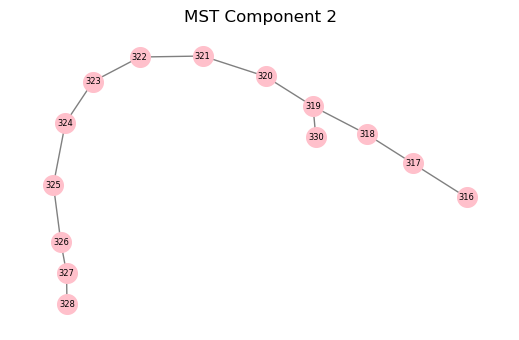

In [21]:
component_2 = list(components[1])

subgraph = mst_stra.subgraph(component_2)

plt.figure(figsize=(5, 3))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=200, node_color='pink', font_size=6, edge_color='gray')
plt.title("MST Component 2")
plt.show()


In [22]:
# all nodes in component 2
component_2_nodes = list(components[1])
print(f"Component 2 Nodes: {component_2_nodes}")

# all paths in component 2
component_2_lines = df_merged[
    (df_merged['station1'].isin(component_2_nodes)) | 
    (df_merged['station2'].isin(component_2_nodes))
]

print(f"Component 2 Lines (total {len(component_2_lines)}):")
print(component_2_lines[['line', 'station1', 'station2']].drop_duplicates())

# get the unique line
unique_lines = component_2_lines['line'].unique()
print(f"Unique Lines in Component 2: {unique_lines}")

Component 2 Nodes: [320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 316, 317, 318, 319]
Component 2 Lines (total 13):
     line  station1  station2
418    14       316       317
419    14       317       318
420    14       318       319
421    14       319       320
422    14       320       321
423    14       321       322
424    14       322       323
425    14       323       324
426    14       324       325
427    14       325       326
428    14       326       327
429    14       327       328
430    14       319       330
Unique Lines in Component 2: [14]


In [23]:
# all nodes in component 1
component_1_nodes = list(components[0])

# all paths in component 1
component_1_lines = df_merged[
    (df_merged['station1'].isin(component_1_nodes)) | 
    (df_merged['station2'].isin(component_1_nodes))
]

# unique line
component_1_unique_lines = component_1_lines['line'].unique()
print(f"Component 1 Unique Lines: {component_1_unique_lines}")


Component 1 Unique Lines: [ 1  2  3  4 13  5  6  7  8  9 10 11 12 14]


In [24]:
# check line 14 components
df_14 = df_con[df_con['line']==14]

G_14 = nx.Graph()

# add edges from df_14
for _, row in df_14.iterrows():
    if not pd.isna(row['distance(miles)']):
        G_14.add_edge(row['station1'], row['station2'], weight=row['distance(miles)'])

# check if the graph is fully connected
is_connected = nx.is_connected(G_14)
print(f"Is the graph fully connected? {is_connected}")

# If not connected, find how many components and their sizes
if not is_connected:
    components = list(nx.connected_components(G_14))
    print(f"Number of components: {len(components)}")
    for i, comp in enumerate(components, 1):
        print(f"Component {i}: {len(comp)} stations")

    # display the stations in each component
    for i, comp in enumerate(components, 1):
        print(f"Stations in Component {i}: {sorted(comp)}")

Is the graph fully connected? False
Number of components: 2
Component 1: 11 stations
Component 2: 14 stations
Stations in Component 1: [28.0, 42.0, 63.0, 92.0, 156.0, 193.0, 259.0, 295.0, 304.0, 305.0, 314.0]
Stations in Component 2: [316.0, 317.0, 318.0, 319.0, 320.0, 321.0, 322.0, 323.0, 324.0, 325.0, 326.0, 327.0, 328.0, 330.0]


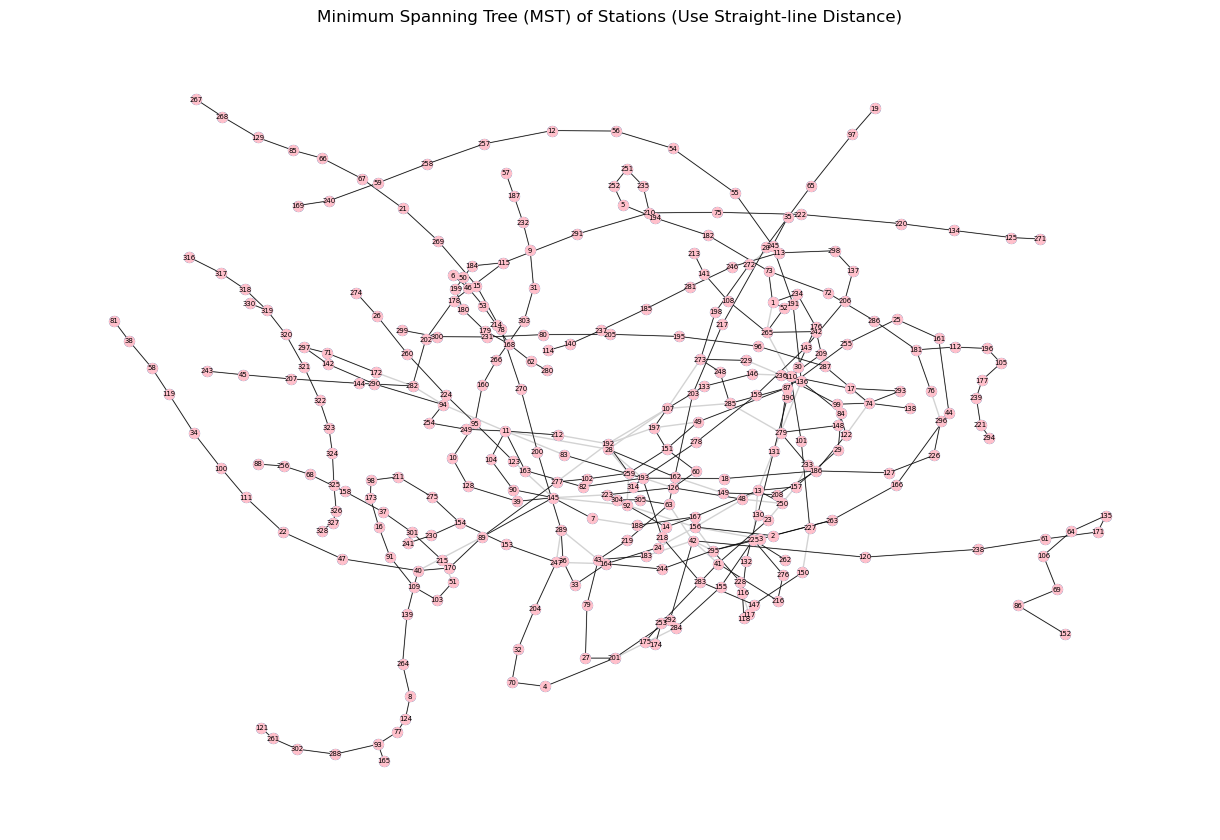

In [25]:
pos = nx.spring_layout(G_stra, seed=43)

plt.figure(figsize=(12, 8))
nx.draw(G_stra, pos, with_labels=True, node_size=50, edge_color="lightgray", alpha=1, font_size=5)
nx.draw_networkx_edges(mst_stra, pos, edge_color="black", width=0.5)
nx.draw_networkx_nodes(G_stra, pos, node_color="pink", node_size=50)

plt.title("Minimum Spanning Tree (MST) of Stations (Use Straight-line Distance)")
plt.show()

### 2. Repeat this computation, now using the length of connections provided in the data.

In [26]:
# # check whether the the different lines between two stations will result in differnt distance.
# c = 0
# for i in range(len(df_merged)):
#     for j in range(len(df_merged)):
#         curr_n_dis = df_merged.loc[(df_merged['station1'] == i) & (df_merged['station2'] == j)]
#         if len(curr_n_dis) > 1:
#             d = list(curr_n_dis['distance(miles)'])
#             n1 = d[0]
#             for n in d:
#                 if n != n1:
#                     c += 1
# print(c) # c=0

In [27]:
cost_dist, _, edges_dist = mst_cost(graph, 'distance(miles)', 0) # use index 0 as the starting node
print(f'Minimun Spanning Tree cost using length of connections provided in the data: {cost_dist} miles')

Minimun Spanning Tree cost using length of connections provided in the data: 241.70918746776908 miles


use library

In [28]:
# create an undirected graph
G_dist = nx.Graph()

for _, row in df_merged.iterrows():
    station1, station2, distance = row["station1"], row["station2"], row["distance(miles)"]
    G_dist.add_edge(int(station1), int(station2), weight=distance) # add nodes and edge to the graph

# compute the MST
mst_dist = nx.minimum_spanning_tree(G_dist, algorithm="prim")

# get the mst cost 
m_cost_dist = sum(edge[2]['weight'] for edge in mst_dist.edges(data=True)) # each edge: (node1, node2, edge_attributes_dict -> {'weight': ...})
print(f'Minimun Spanning Tree cost using length of connections provided in the data: {m_cost_dist} miles')


Minimun Spanning Tree cost using length of connections provided in the data: 257.4428708321856 miles


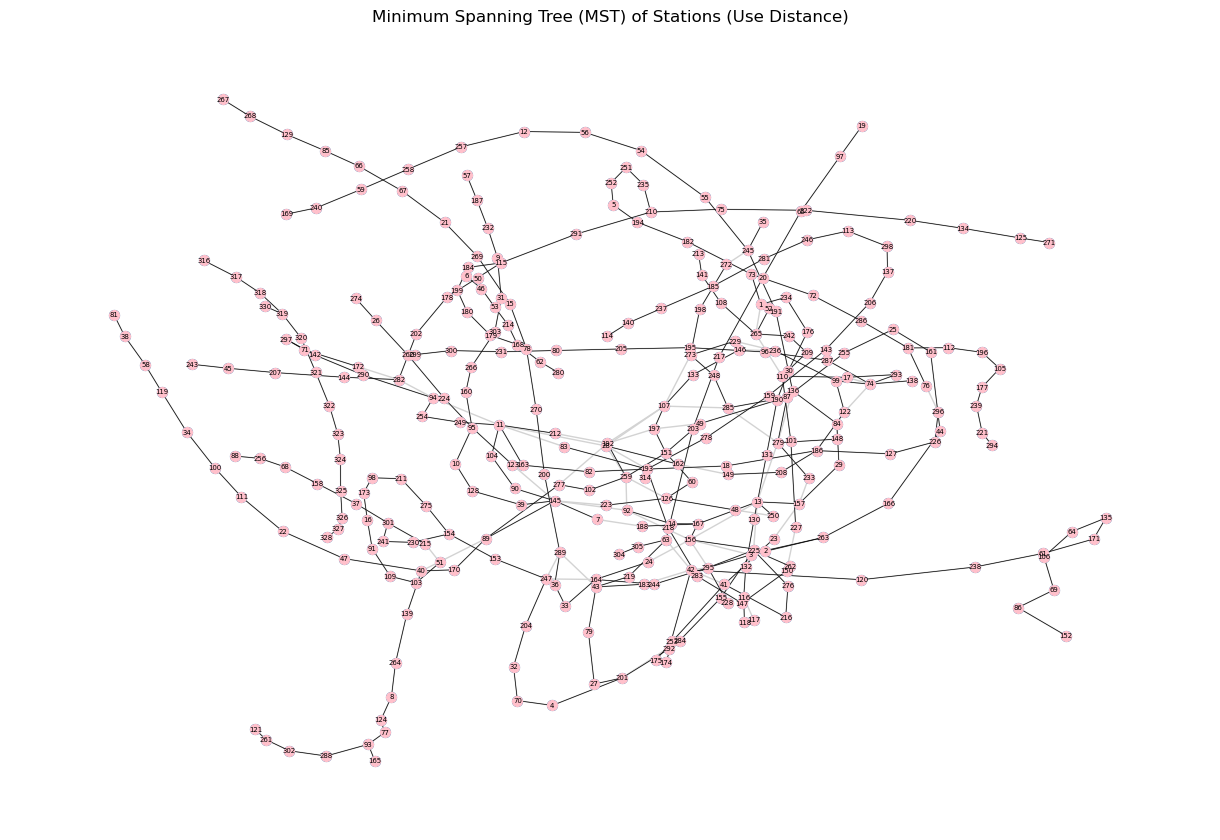

In [29]:
pos = nx.spring_layout(G_dist, seed=43)

plt.figure(figsize=(12, 8))
nx.draw(G_dist, pos, with_labels=True, node_size=50, edge_color="lightgray", alpha=1, font_size=5)
nx.draw_networkx_edges(mst_stra, pos, edge_color="black", width=0.5)
nx.draw_networkx_nodes(G_dist, pos, node_color="pink", node_size=50)

plt.title("Minimum Spanning Tree (MST) of Stations (Use Distance)")
plt.show()

### 3. Using version 2 of the lengths, I will investigate the robustness of the computation.  I conduct 10000 experiments.  In each experiment the length of each connection is adjusted as follows:
        modified length = max{ (true length)*(1 + Gaussian(0,0.3)), 0.01*(true length) }
i.e., I modify the length randomly using a zero-norm Gaussian distribution with standard deviation 0.3 and correct if the length becomes too small.

Plot the distribution of minimum spanning tree lengths, as well as the Value-At-Risk at level 5%.

In [30]:
costs_m = []

for i in tqdm(range(10000)):

    graph_modified = defaultdict(dict) 
    for s1, s2, d_distance in zip(df_merged['station1'], df_merged['station2'],df_merged['distance(miles)']):
        d_modifed = max(d_distance * (1 + np.random.normal(0, 0.3)), 0.01 * d_distance)
        graph_modified[s1][s2] = (_, _, d_modifed) # set d_modifed to have index of 2 (0 for distance, 1 for straight-line distance)
        graph_modified[s2][s1] = (_, _, d_modifed)  

    cost_modified, _, _ = mst_cost(graph_modified, 'modified_length', 0)  
    costs_m.append(cost_modified)


100%|██████████| 10000/10000 [00:05<00:00, 1699.01it/s]


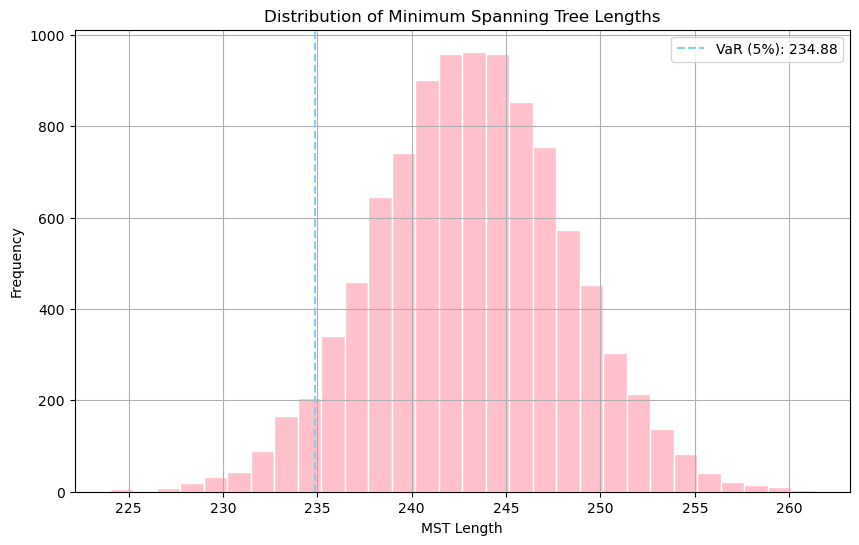

In [31]:
# Compute Value-at-Risk (VaR) at 5% level to estimates potential losses at a given confidence level.
# only 5% of the observed MST lengths fall.
VaR_5 = np.percentile(costs_m, 5)

plt.figure(figsize=(10, 6))
plt.hist(costs_m, bins=30, color='pink', edgecolor='white')
plt.axvline(VaR_5, color='skyblue', linestyle='dashed', label=f'VaR (5%): {VaR_5:.2f}')
plt.title("Distribution of Minimum Spanning Tree Lengths")
plt.xlabel("MST Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.show()


Use Library

In [32]:
mst_lengths = []

for _ in tqdm(range(10000)):
    
    # modify edge lengths using Gaussian distribution
    G_dist_modifed = nx.Graph()

    for _, row in df_merged.iterrows():
        station1, station2, distance = row["station1"], row["station2"], row["distance(miles)"]
        G_dist_modifed.add_edge(int(station1), int(station2), weight=distance) # add nodes and edge to the graph
    dist_edge_lib = G_dist_modifed.edges(data=True)

    for u, v, d in dist_edge_lib:
        
        true_length = d['weight']
        if true_length < 0.01:
            print(true_length)
        r = np.random.normal(0, 0.3)
        
        modified_length = max(true_length * (1 + r), 0.01 * true_length)
        # if modified_length < 0.1:
        #     print(modified_length) 
        G_dist_modifed[u][v]['weight'] = modified_length

    
    # compute MST with modified lengths
    mst_modified = nx.minimum_spanning_tree(G_dist_modifed, algorithm="prim")
    mst_length = sum(edge[2]['weight'] for edge in mst_modified.edges(data=True))
    mst_lengths.append(mst_length)


100%|██████████| 10000/10000 [01:07<00:00, 147.51it/s]


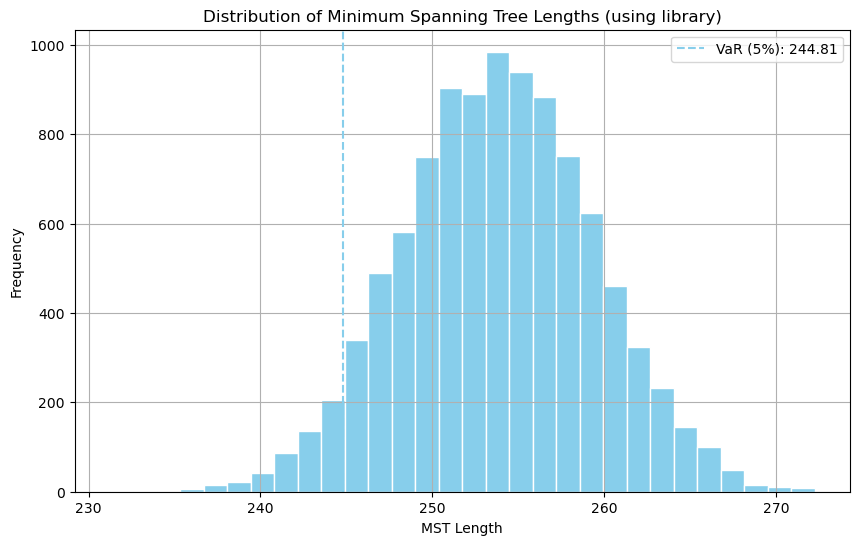

In [33]:
# Compute Value-at-Risk (VaR) at 5% level to estimates potential losses at a given confidence level.
VaR_5 = np.percentile(mst_lengths, 5)

plt.figure(figsize=(10, 6))
plt.hist(mst_lengths, bins=30, color='skyblue', edgecolor='white')
plt.axvline(VaR_5, color='skyblue', linestyle='dashed', label=f'VaR (5%): {VaR_5:.2f}')
plt.title("Distribution of Minimum Spanning Tree Lengths (using library)")
plt.xlabel("MST Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.show()


#### 4. Returning to the lengths as in version 2, conduct a delete-and-repair analysis.  That is to say, for each link L of the minimum spanning tree, 

    (a) Remove L from the network.
    
    (b) Compute a minimum spanning tree for the network with L (and only L) removed.  

  Plot the resulting values for the length of the minimum spanning tree.

Note: I only remove one link at a time.

In [34]:
removed_costs = []

for i, j in edges_dist:
    graph_ij = graph[i][j]
    graph_ji = graph[j][i]
    del graph[i][j]
    del graph[j][i]

    c_revised, _, _ = mst_cost(graph, 'distance(miles)', 0) 
    removed_costs.append(c_revised)

    graph[i][j] = graph_ij
    graph[j][i] = graph_ji
    

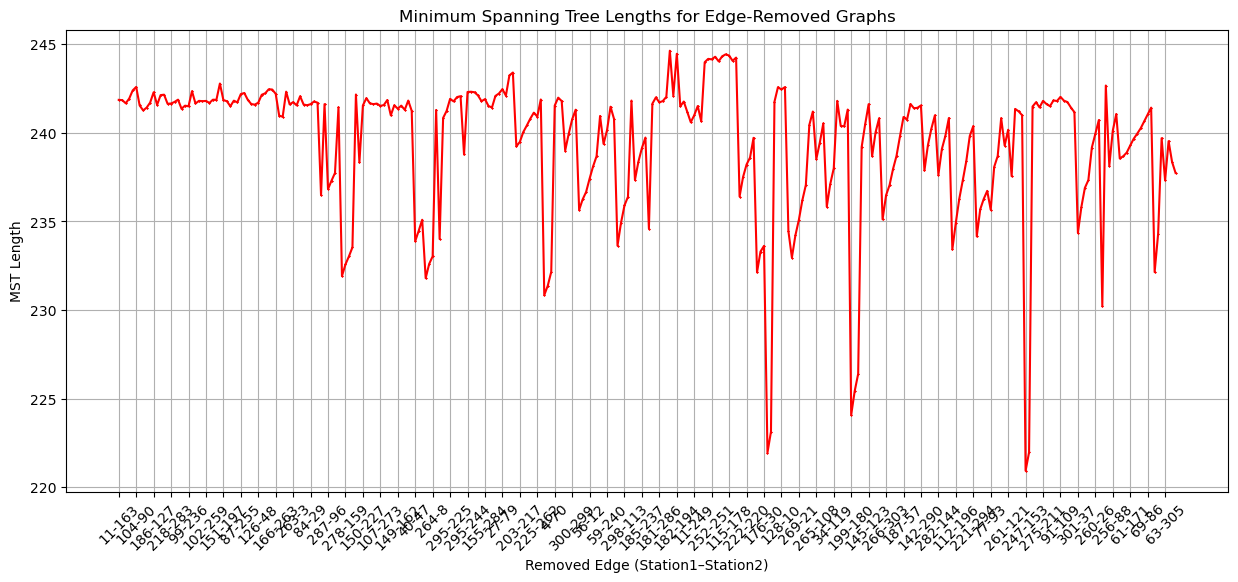

In [35]:
edge_labels = [f"{e[0]}-{e[1]}" for e in edges_dist]

plt.figure(figsize=(15, 6))
plt.plot(edge_labels, removed_costs, marker='x', markersize=1, linestyle='-', color='red')

plt.title("Minimum Spanning Tree Lengths for Edge-Removed Graphs")
plt.xlabel("Removed Edge (Station1–Station2)")
plt.ylabel("MST Length")
plt.xticks(edge_labels[::5], rotation=45)
plt.grid(True)

plt.show()


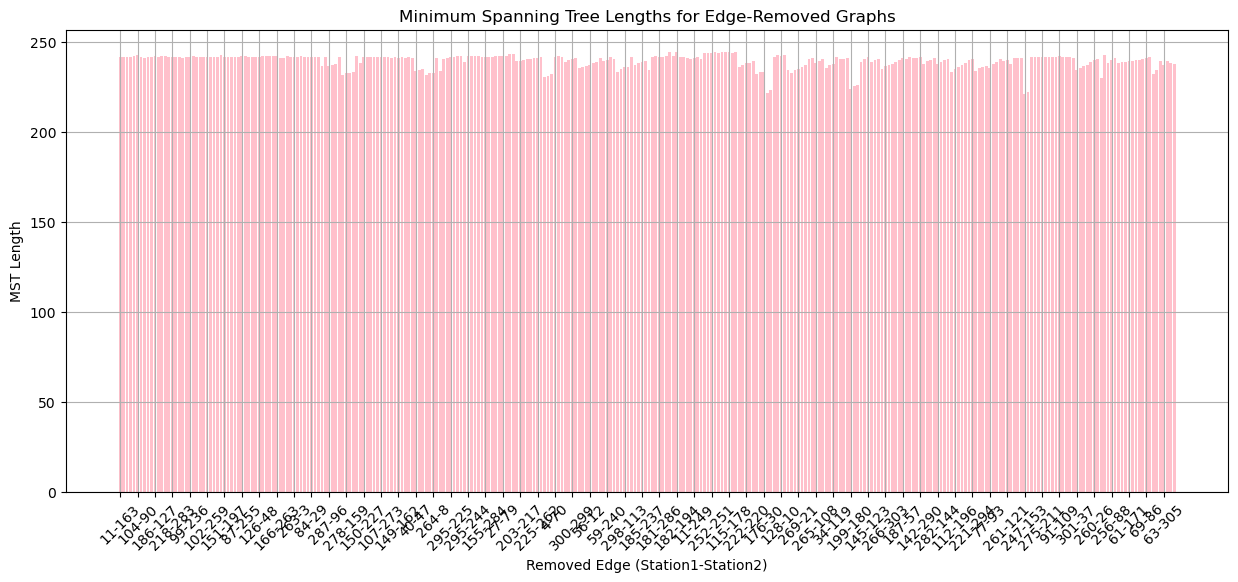

In [36]:
# bar
edge_labels = [f"{e[0]}-{e[1]}" for e in edges_dist]

plt.figure(figsize=(15, 6))
plt.bar(edge_labels, removed_costs, color='pink')

plt.title("Minimum Spanning Tree Lengths for Edge-Removed Graphs")
plt.xlabel("Removed Edge (Station1-Station2)")
plt.ylabel("MST Length")
plt.xticks(edge_labels[::5], rotation=45)
plt.grid(True)

plt.show()

In [37]:
# create an undirected graph
G_dist = nx.Graph()

for _, row in df_merged.iterrows():
    station1, station2, distance = row["station1"], row["station2"], row["distance(miles)"]
    G_dist.add_edge(int(station1), int(station2), weight=distance) # add nodes and edge to the graph

# compute the MST
mst_dist = nx.minimum_spanning_tree(G_dist, algorithm="prim")

# get the mst cost 
m_cost_dist = sum(edge[2]['weight'] for edge in mst_dist.edges(data=True)) # each edge: (node1, node2, edge_attributes_dict -> {'weight': ...})
print(f'Minimun Spanning Tree cost using length of connections provided in the data: {m_cost_dist} miles')

Minimun Spanning Tree cost using length of connections provided in the data: 257.4428708321856 miles


use library

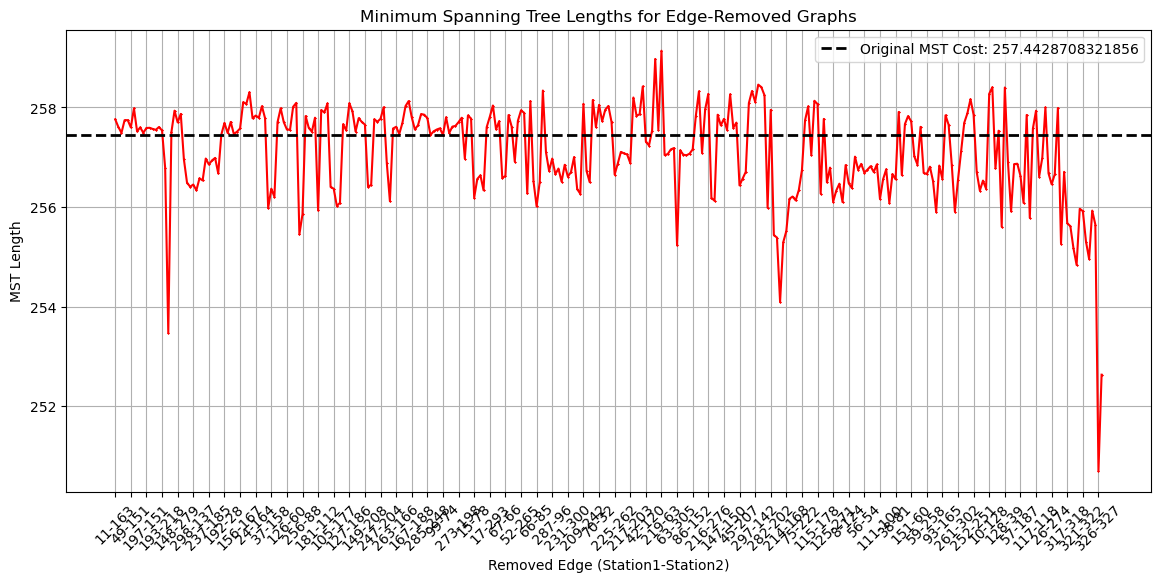

In [39]:
G_dist = nx.Graph()

for _, row in df_merged.iterrows():
    station1, station2, distance = row["station1"], row["station2"], row["distance(miles)"]
    G_dist.add_edge(int(station1), int(station2), weight=distance)

mst_dist = nx.minimum_spanning_tree(G_dist, algorithm="prim")
original_mst_cost = sum(edge[2]['weight'] for edge in mst_dist.edges(data=True))

mst_costs_after_removal = []
edge_labels = []

for edge in list(mst_dist.edges()):
    G_temp = G_dist.copy()

    G_temp.remove_edge(*edge)
    
    new_mst = nx.minimum_spanning_tree(G_temp, algorithm="prim")
    new_mst_cost = sum(e[2]['weight'] for e in new_mst.edges(data=True))
    
    mst_costs_after_removal.append(new_mst_cost)
    edge_labels.append(f"{edge[0]}-{edge[1]}")

plt.figure(figsize=(14, 6))
plt.plot(edge_labels, mst_costs_after_removal, marker='x', markersize=1, linestyle='-', color='red')
plt.axhline(original_mst_cost, color='black', linestyle='dashed', linewidth=2, label=f'Original MST Cost: {original_mst_cost}')
plt.xticks(edge_labels[::5], rotation=45)
plt.xlabel("Removed Edge (Station1-Station2)")
plt.ylabel("MST Length")
plt.title("Minimum Spanning Tree Lengths for Edge-Removed Graphs")
plt.legend()
plt.grid(True)
plt.show()

